In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.insert(0, './')
from functions import *
import warnings
warnings.filterwarnings('ignore')

# Identify Vulnerable Tracts


In [348]:
filename = 'Data/Cleaned/postprocessed.pkl'
with open(filename, mode='rb') as f:
    df = pickle.load(f)

In [316]:
# TODO: figure out if dollar amounts in ACS are inflation adjusted or not

def find_vulnerable_tracts(df, year):
    
    # limit df to date provided
    df_yr = df[df.year==year]
    threshold_white = df_yr.percent_white.quantile(.7)
    threshold_income = df_yr.med_income.quantile(.7)
    
    # define eligible column if tract meets all criteria
    df_yr['vulnerable'] = np.where(
                            (df_yr.med_income <= threshold_income) &
                              (df_yr.percent_white <= threshold_white), 1, 0)
    vulnerable_tracts = df_yr[df_yr['vulnerable']==1]['full_tract'].unique()

    return df_yr


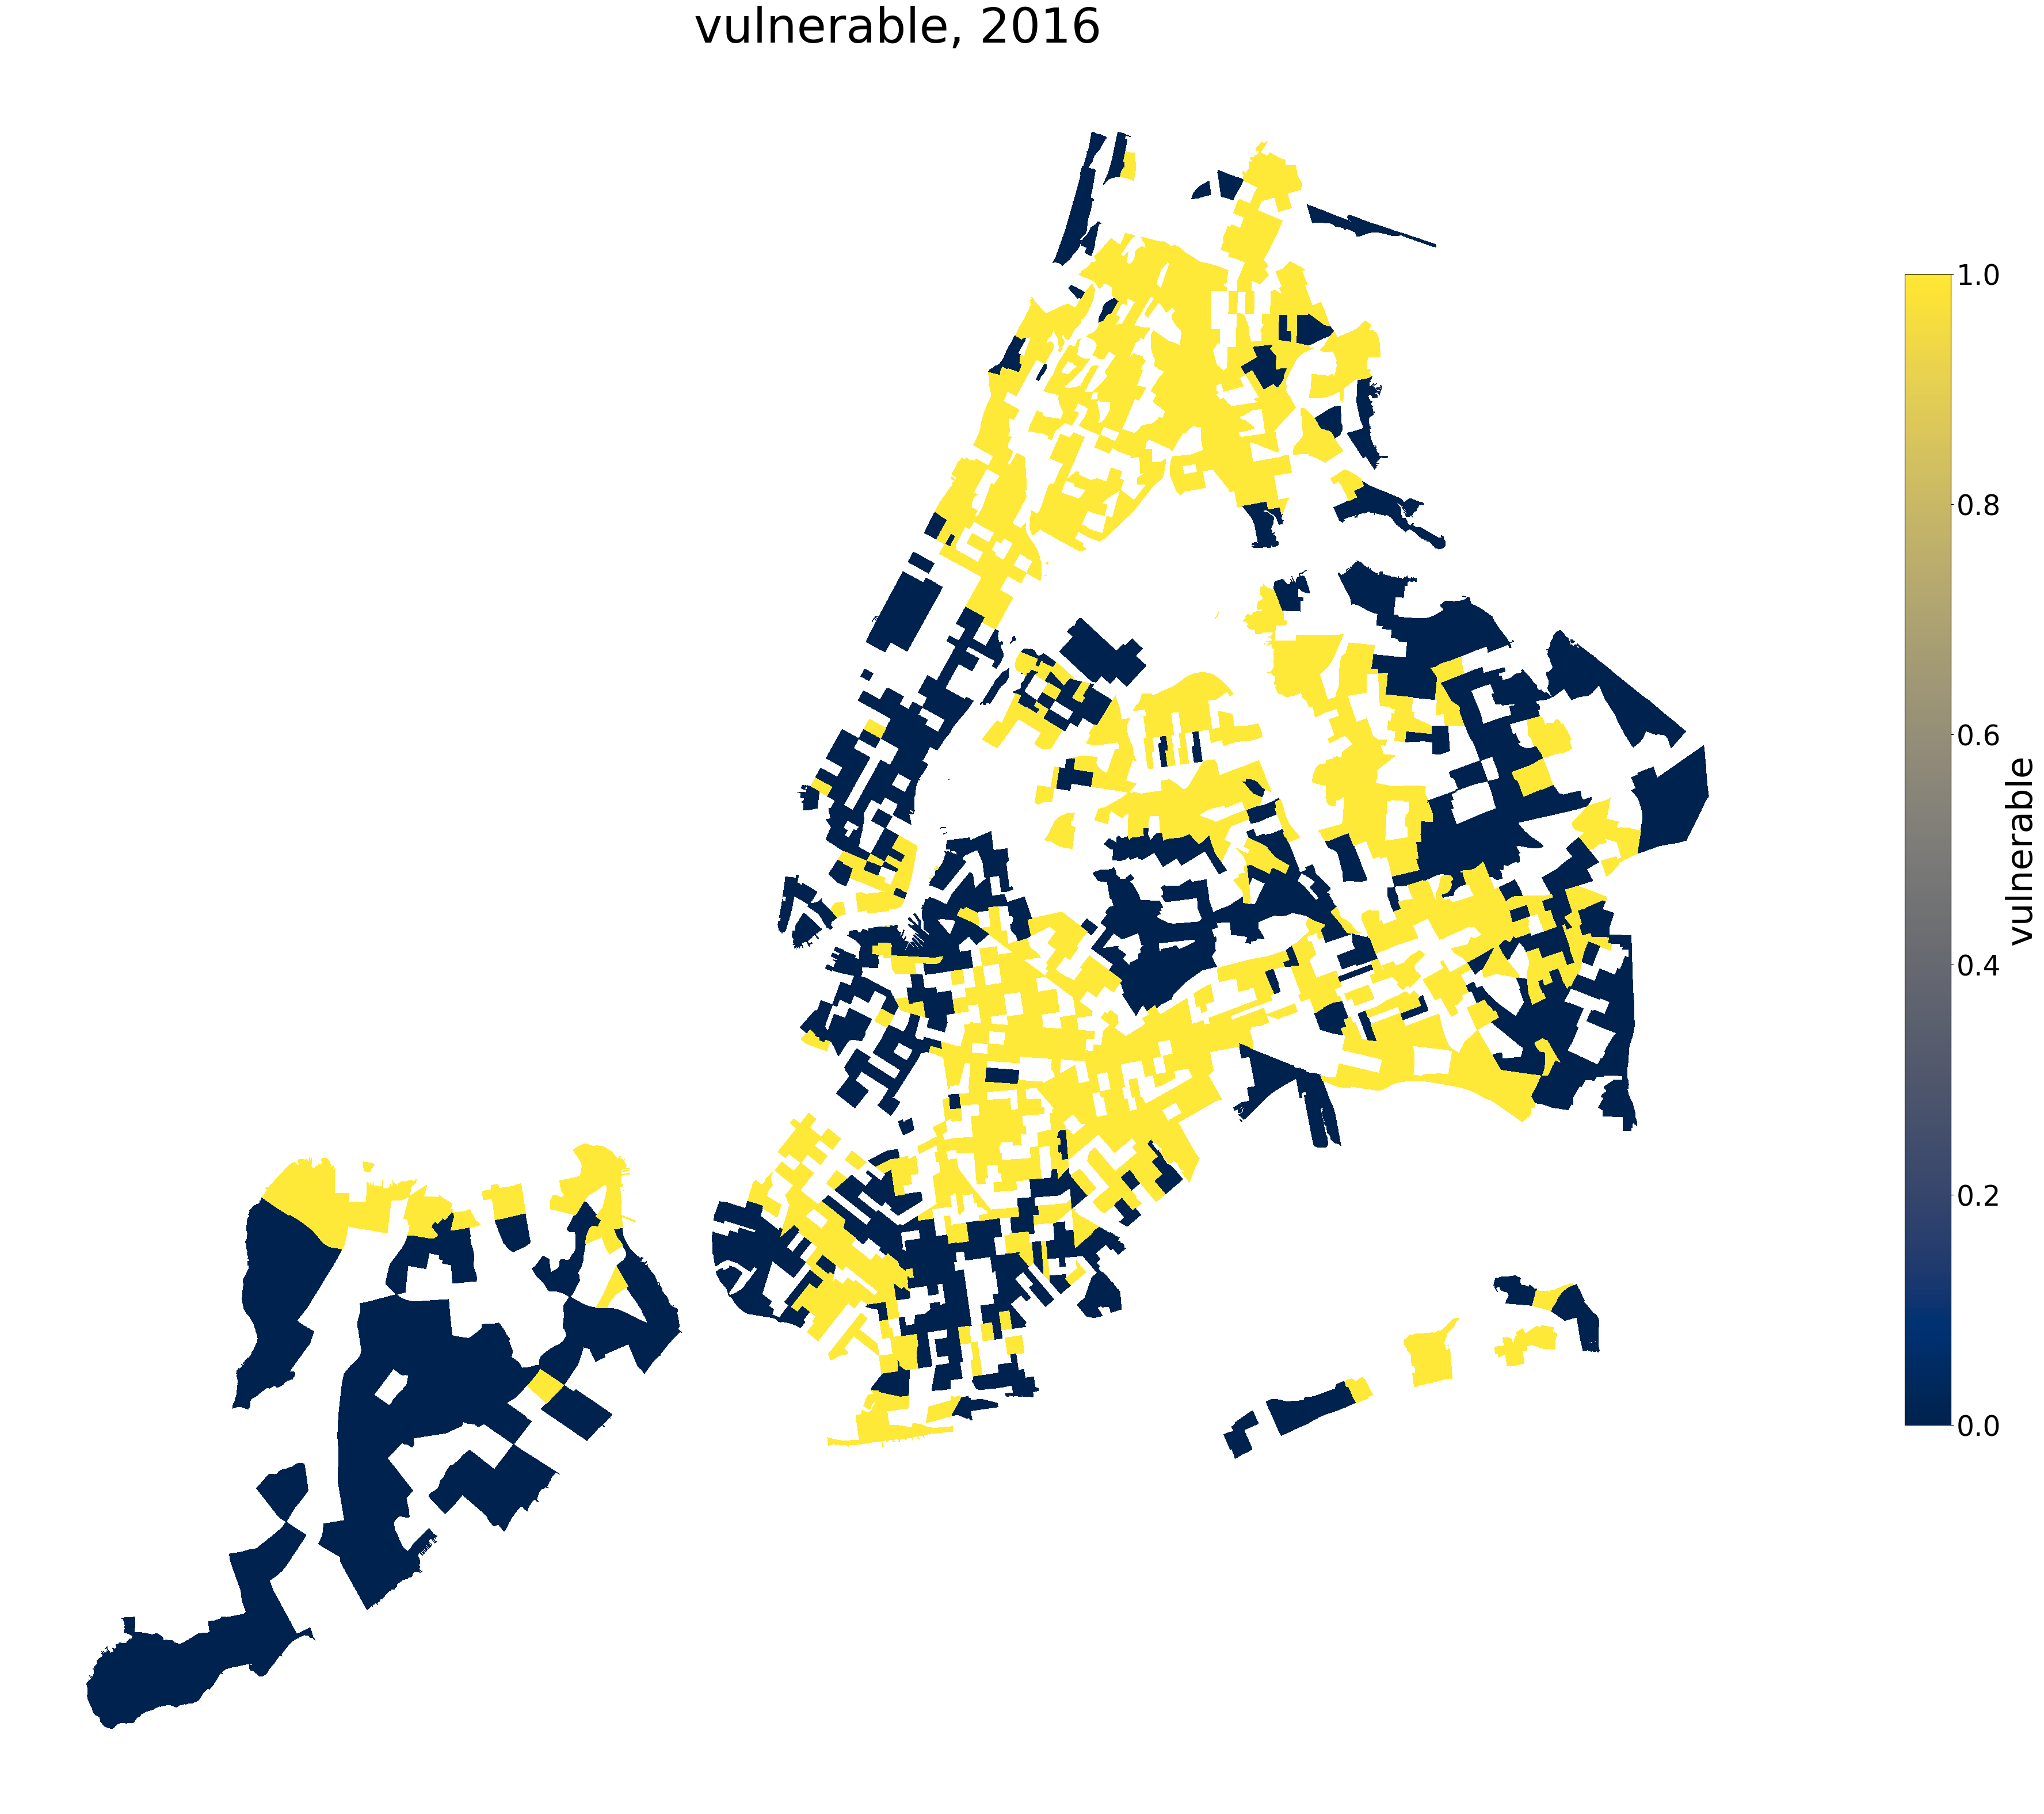

In [317]:
# Test out the function

df_16 = find_vulnerable_tracts(df, '2016')
choropleth(df_16, 'vulnerable', ['2016'], cmap='cividis')


# Identify Gentrified Tracts
We look at percent changes in decade prior to datestamp
- An increase in a tract's percent bachelor’s degrees was in the top third percentile of all tracts within a metro area.
- Increase in percent white is in top 3rd percentile
- The percentage increase in a tract’s inflation-adjusted median income was in the top third percentile of all tracts within a metro area.

In [355]:
def find_gentrified_tracts(df, pred_year):
    df = df[df.year.astype(int) >= int(pred_year)-8]  # limit df to the 8 years prior
    
    # fill zeros with nan so we can calculate percent change
    df.replace(0, np.nan, inplace=True)
    
    # get average percent change over decade
    pct_chg = df.drop(['NAME','year','full_tract', 'vulnerable'], axis=1).groupby('GEOID').agg(lambda x: x.pct_change().mean())
    pct_chg.dropna(how='all', inplace=True)
    pct_chg.fillna(0, inplace=True)

    # Set thresholds. consider it gentrifying if % change is greater than median for region

    # Median White
    threshold_white = pct_chg.percent_white.quantile(.5)

    # Median Bachelors
    threshold_bach = pct_chg.percent_bachelors.quantile(.5)

    # Median HH Median Income
    threshold_income = pct_chg.med_income.quantile(.5)

    # define gentrified column if tract meets all criteria
    pct_chg['gentrified'] = np.where((pct_chg.percent_white>=threshold_white)&
                                 (pct_chg.percent_bachelors>=threshold_bach)&
                                 (pct_chg.med_income>=threshold_income), 1, 0)  # 1 is gentrified, 0 is not
    
    return(pct_chg[['gentrified']].reset_index())
    

## Corroborate labels with UDP 2016

In [186]:
labels_16 = pd.read_excel("Data/Raw/udp_labels_2016.xlsx")
df_16 = find_vulnerable_tracts(df, '2016')

In [204]:

labels_16['udp_labels'] = np.select([labels_16['Type_1.19'].isin(['LI - At Risk of Gentrification',
                                   'LI - Ongoing Gentrification']),
                                        labels_16['Type_1.19'].isin(['LI - Ongoing Displacement of Low-Income Households',
       'LI - Not Losing Low-Income Households']),
                                        labels_16['Type_1.19'].isin(['MHI - Advanced Gentrification',
       'MHI - Ongoing Exclusion', 'MHI - Stable Exclusion',
       'Missing Data', 'VHI - Super Gentrification or Exclusion'])],
                                        [2,1,0], 
                                        -1)
labels_16['geoid'] = labels_16['geoid'].astype(str)
udp_df = df_16.merge(labels_16, left_on='GEOID', right_on='geoid')


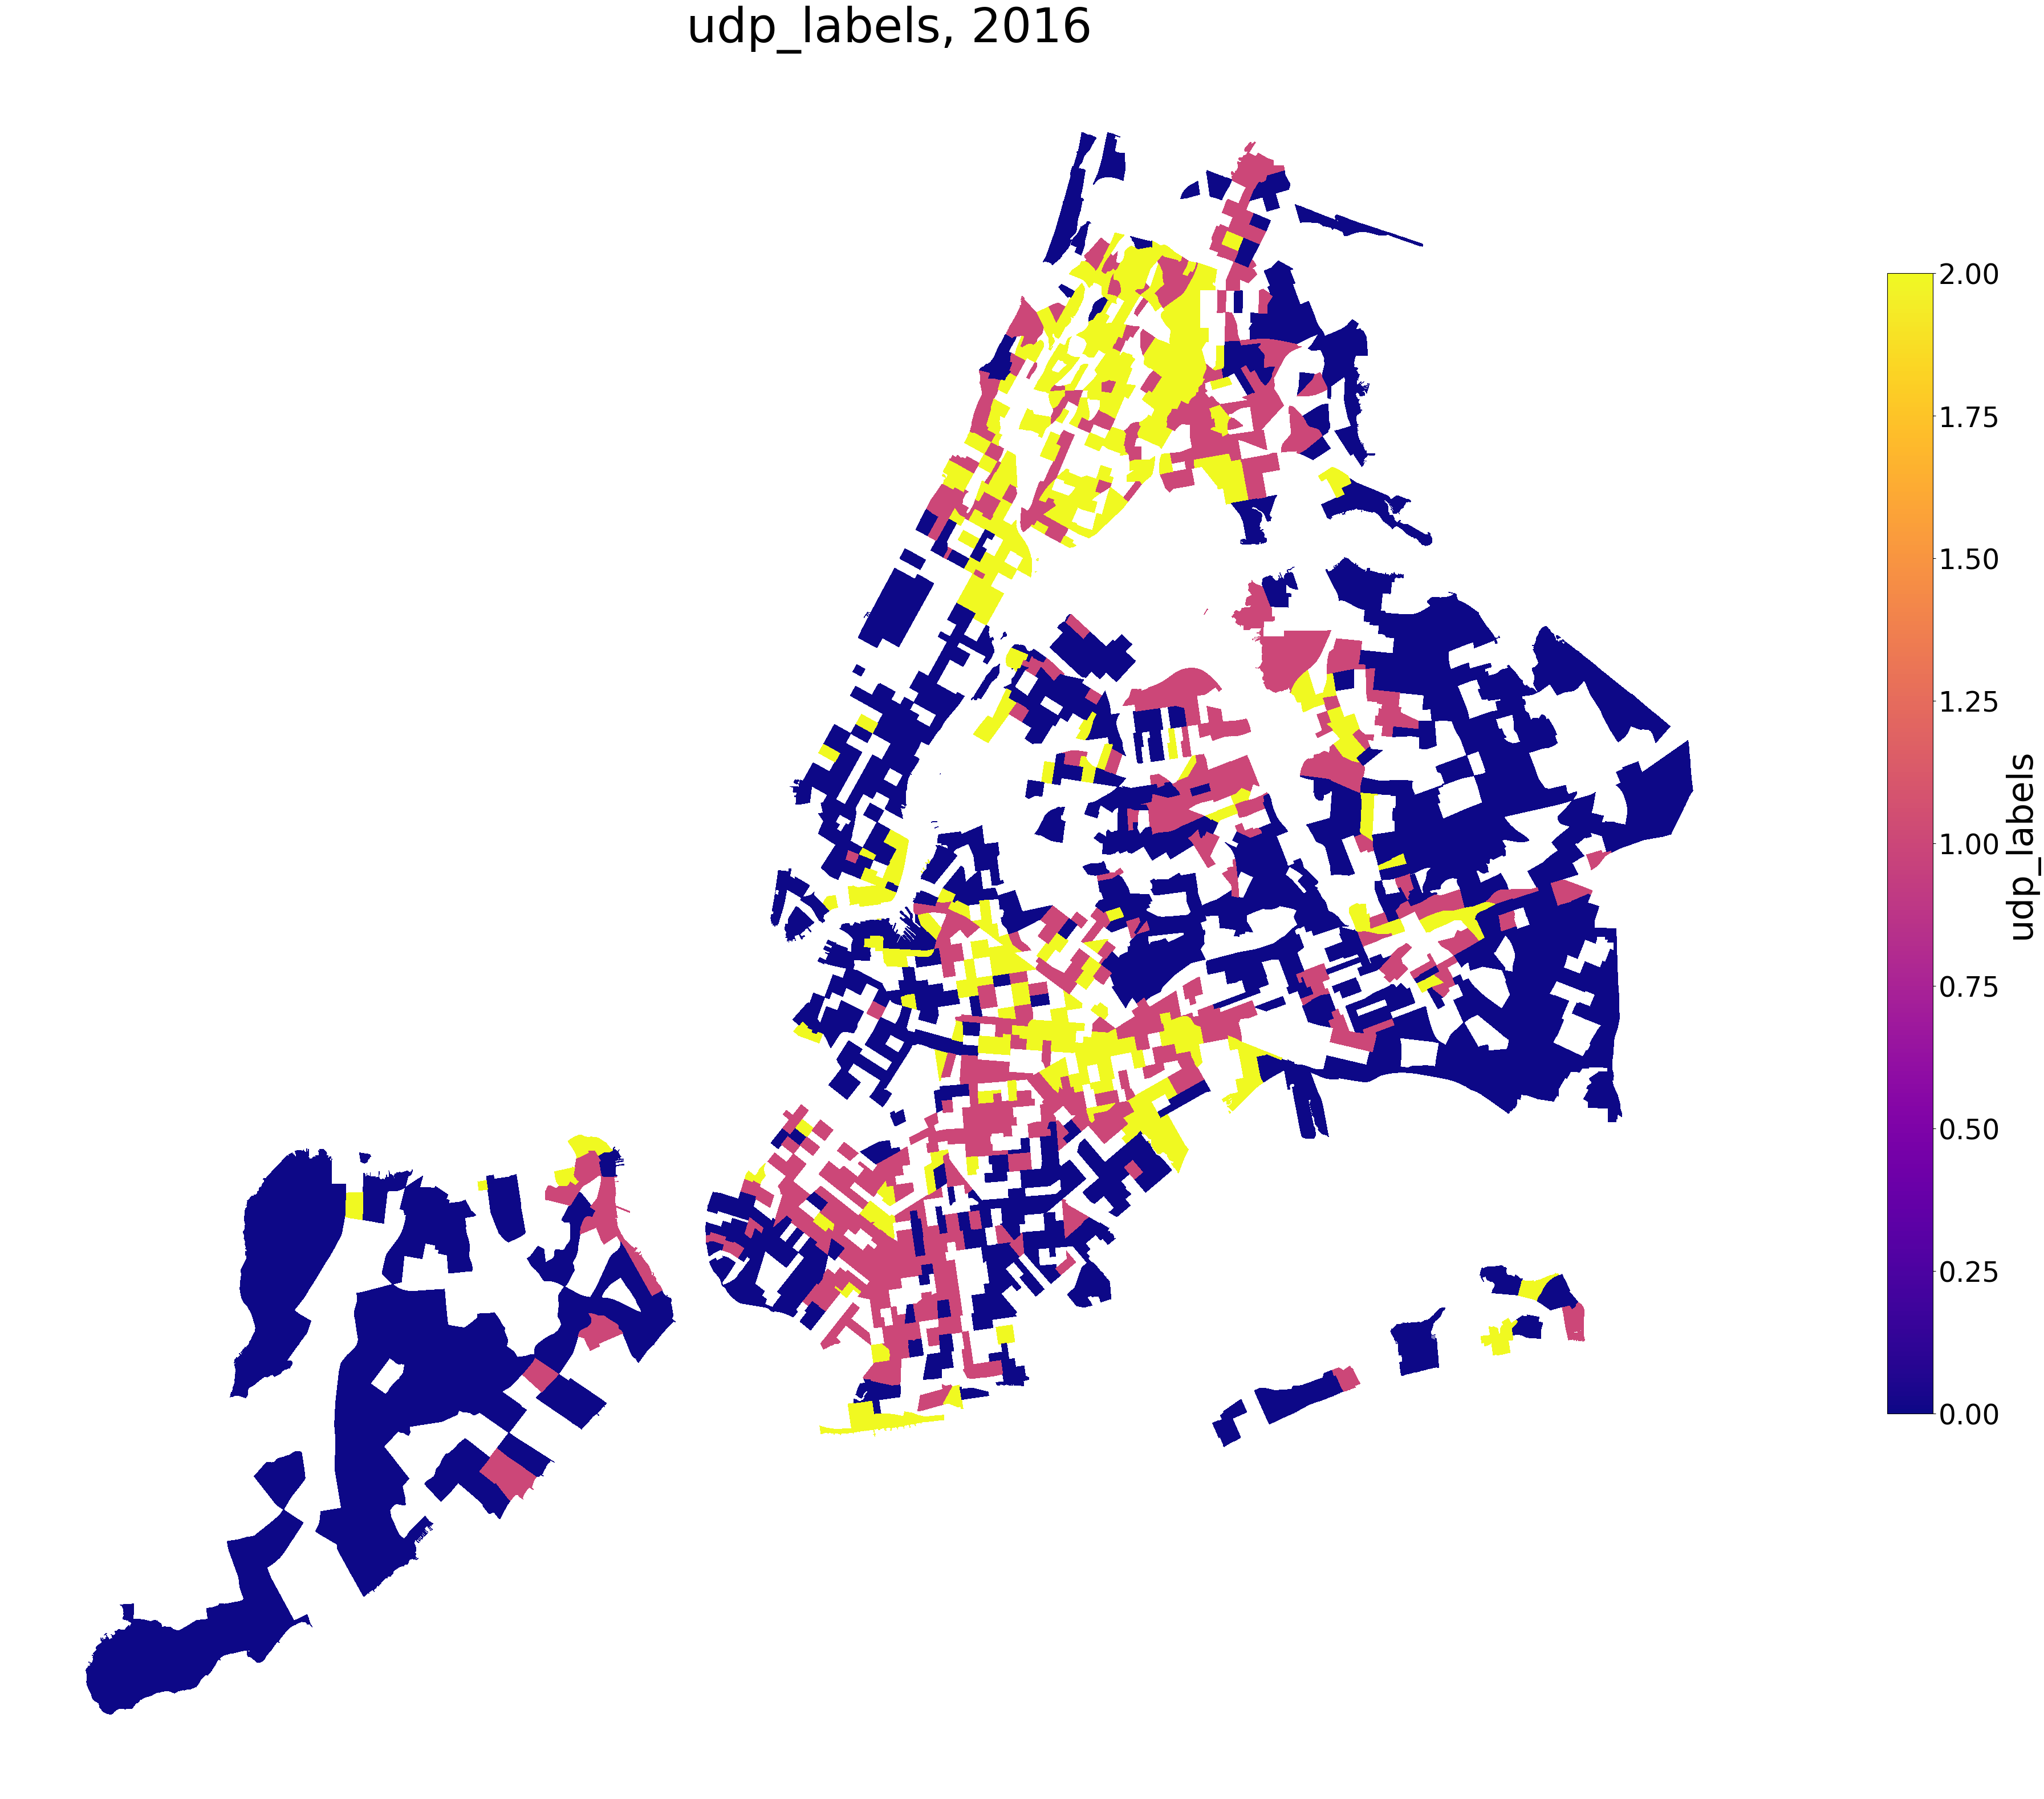

In [205]:
choropleth(udp_df, 'udp_labels', ['2016'], cmap='plasma')

# Construct Labels For Training
- train on features 2010-2016 to predict gentrification status in 2020 (labels from 2020, eligible tracts from 2010)
- train on features 2012-2018 to predict gentrification status in 2022 (labels from 2022, eligible tracts from 2012)

- then use features 2018-2022 to predict gentrification status in 2026 (no labels, eligible tracts are taken from 2016)


In [375]:
def construct_labels(df, yr_vulnerable, yr_gentrified):
    temp_df = df.copy()
    
    # Identify Vulnerable Tracts
    vul_tracts_df = find_vulnerable_tracts(temp_df, yr_vulnerable)
    vul_tracts = vul_tracts_df[vul_tracts_df['vulnerable']==1]['full_tract']
    temp_df['vulnerable'] = np.where(temp_df.full_tract.isin(vul_tracts), 1,0)

    # Identify Gentrified Tracts
    gent_tracts_df = find_gentrified_tracts(temp_df, yr_gentrified)
    gent_tracts = gent_tracts_df[gent_tracts_df['gentrified']==1]['GEOID']
    temp_df['gentrified'] = np.where(temp_df.GEOID.isin(gent_tracts), 1,0)

    # Create label based on vulnerable and gentrified tracts
    temp_df['label'] = np.select([temp_df['gentrified']==1, ((temp_df['gentrified']==0) & 
                                                             (temp_df['vulnerable']==0)), ((temp_df['gentrified']==0) & (temp_df['vulnerable']==1))],
                      [2,0,1],
                      -1)
    return temp_df

In [376]:
labels_2020 = construct_labels(df, '2010','2020')
labels_2022 = construct_labels(df, '2012','2022') 

In [394]:
# labels_2020[['GEOID','label']].drop_duplicates().to_parquet('Data/Cleaned/labels_2020.parquet')
# labels_2022[['GEOID','label']].drop_duplicates().to_parquet('Data/Cleaned/labels_2022.parquet')

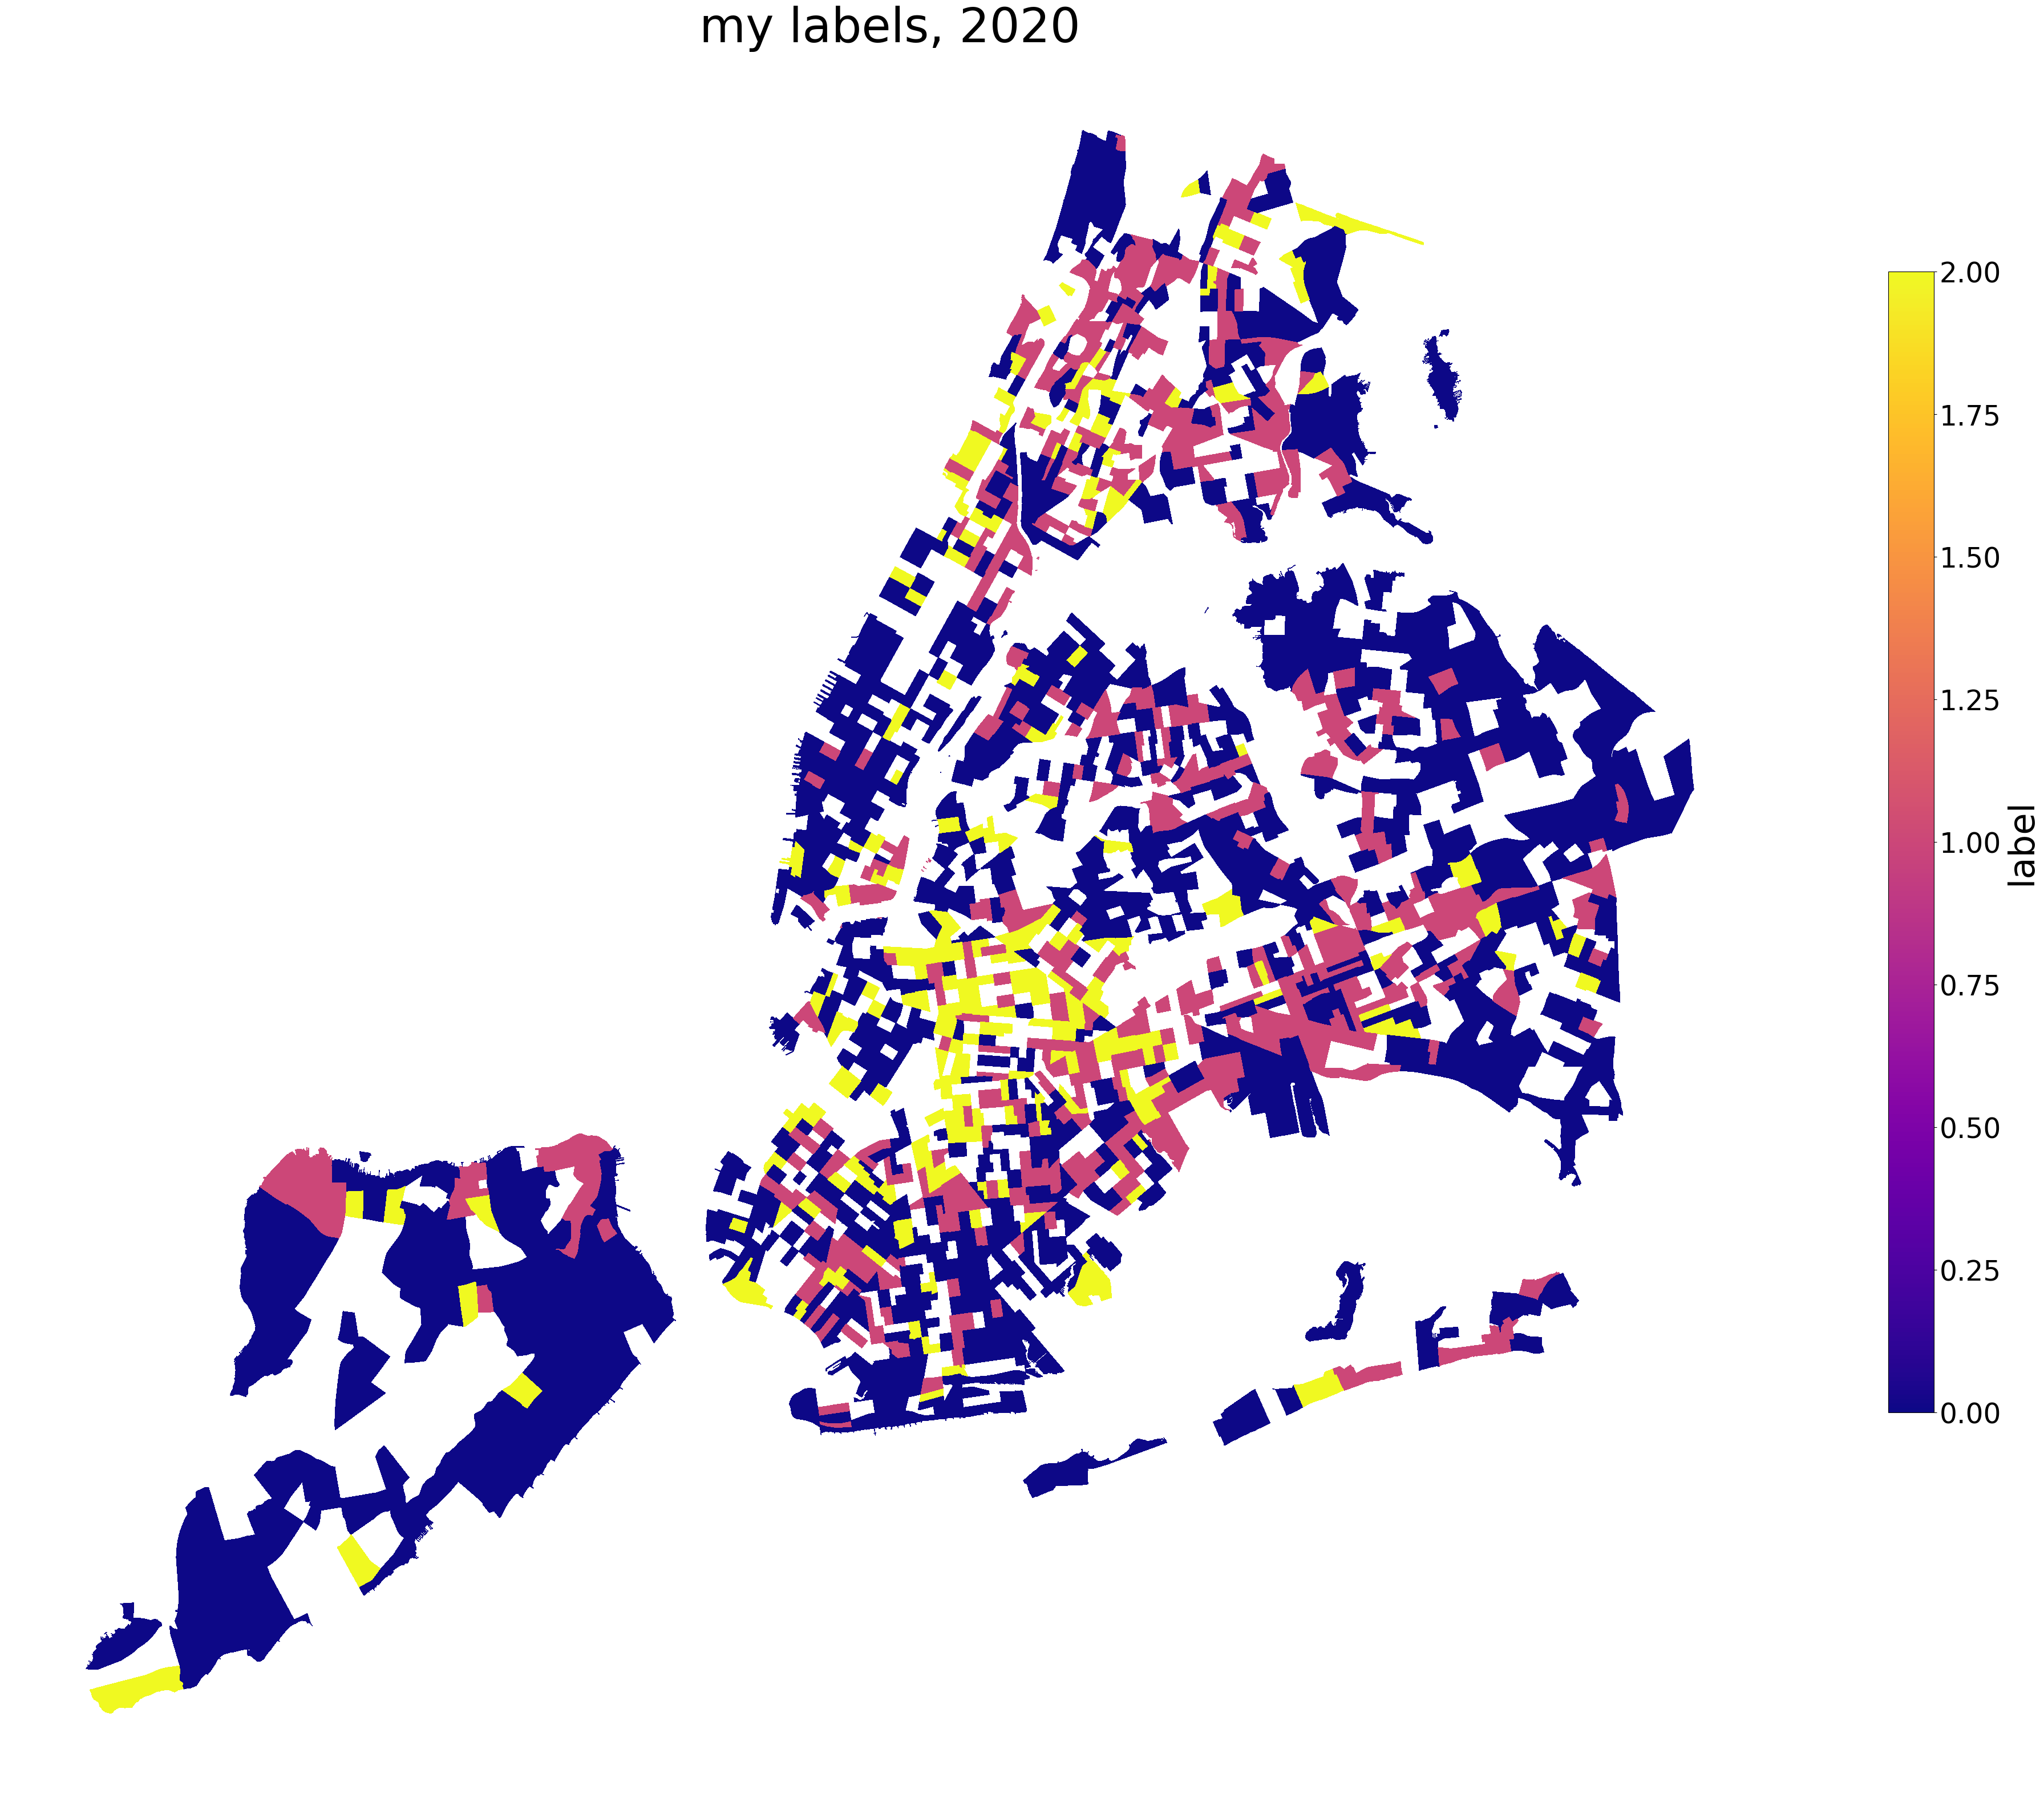

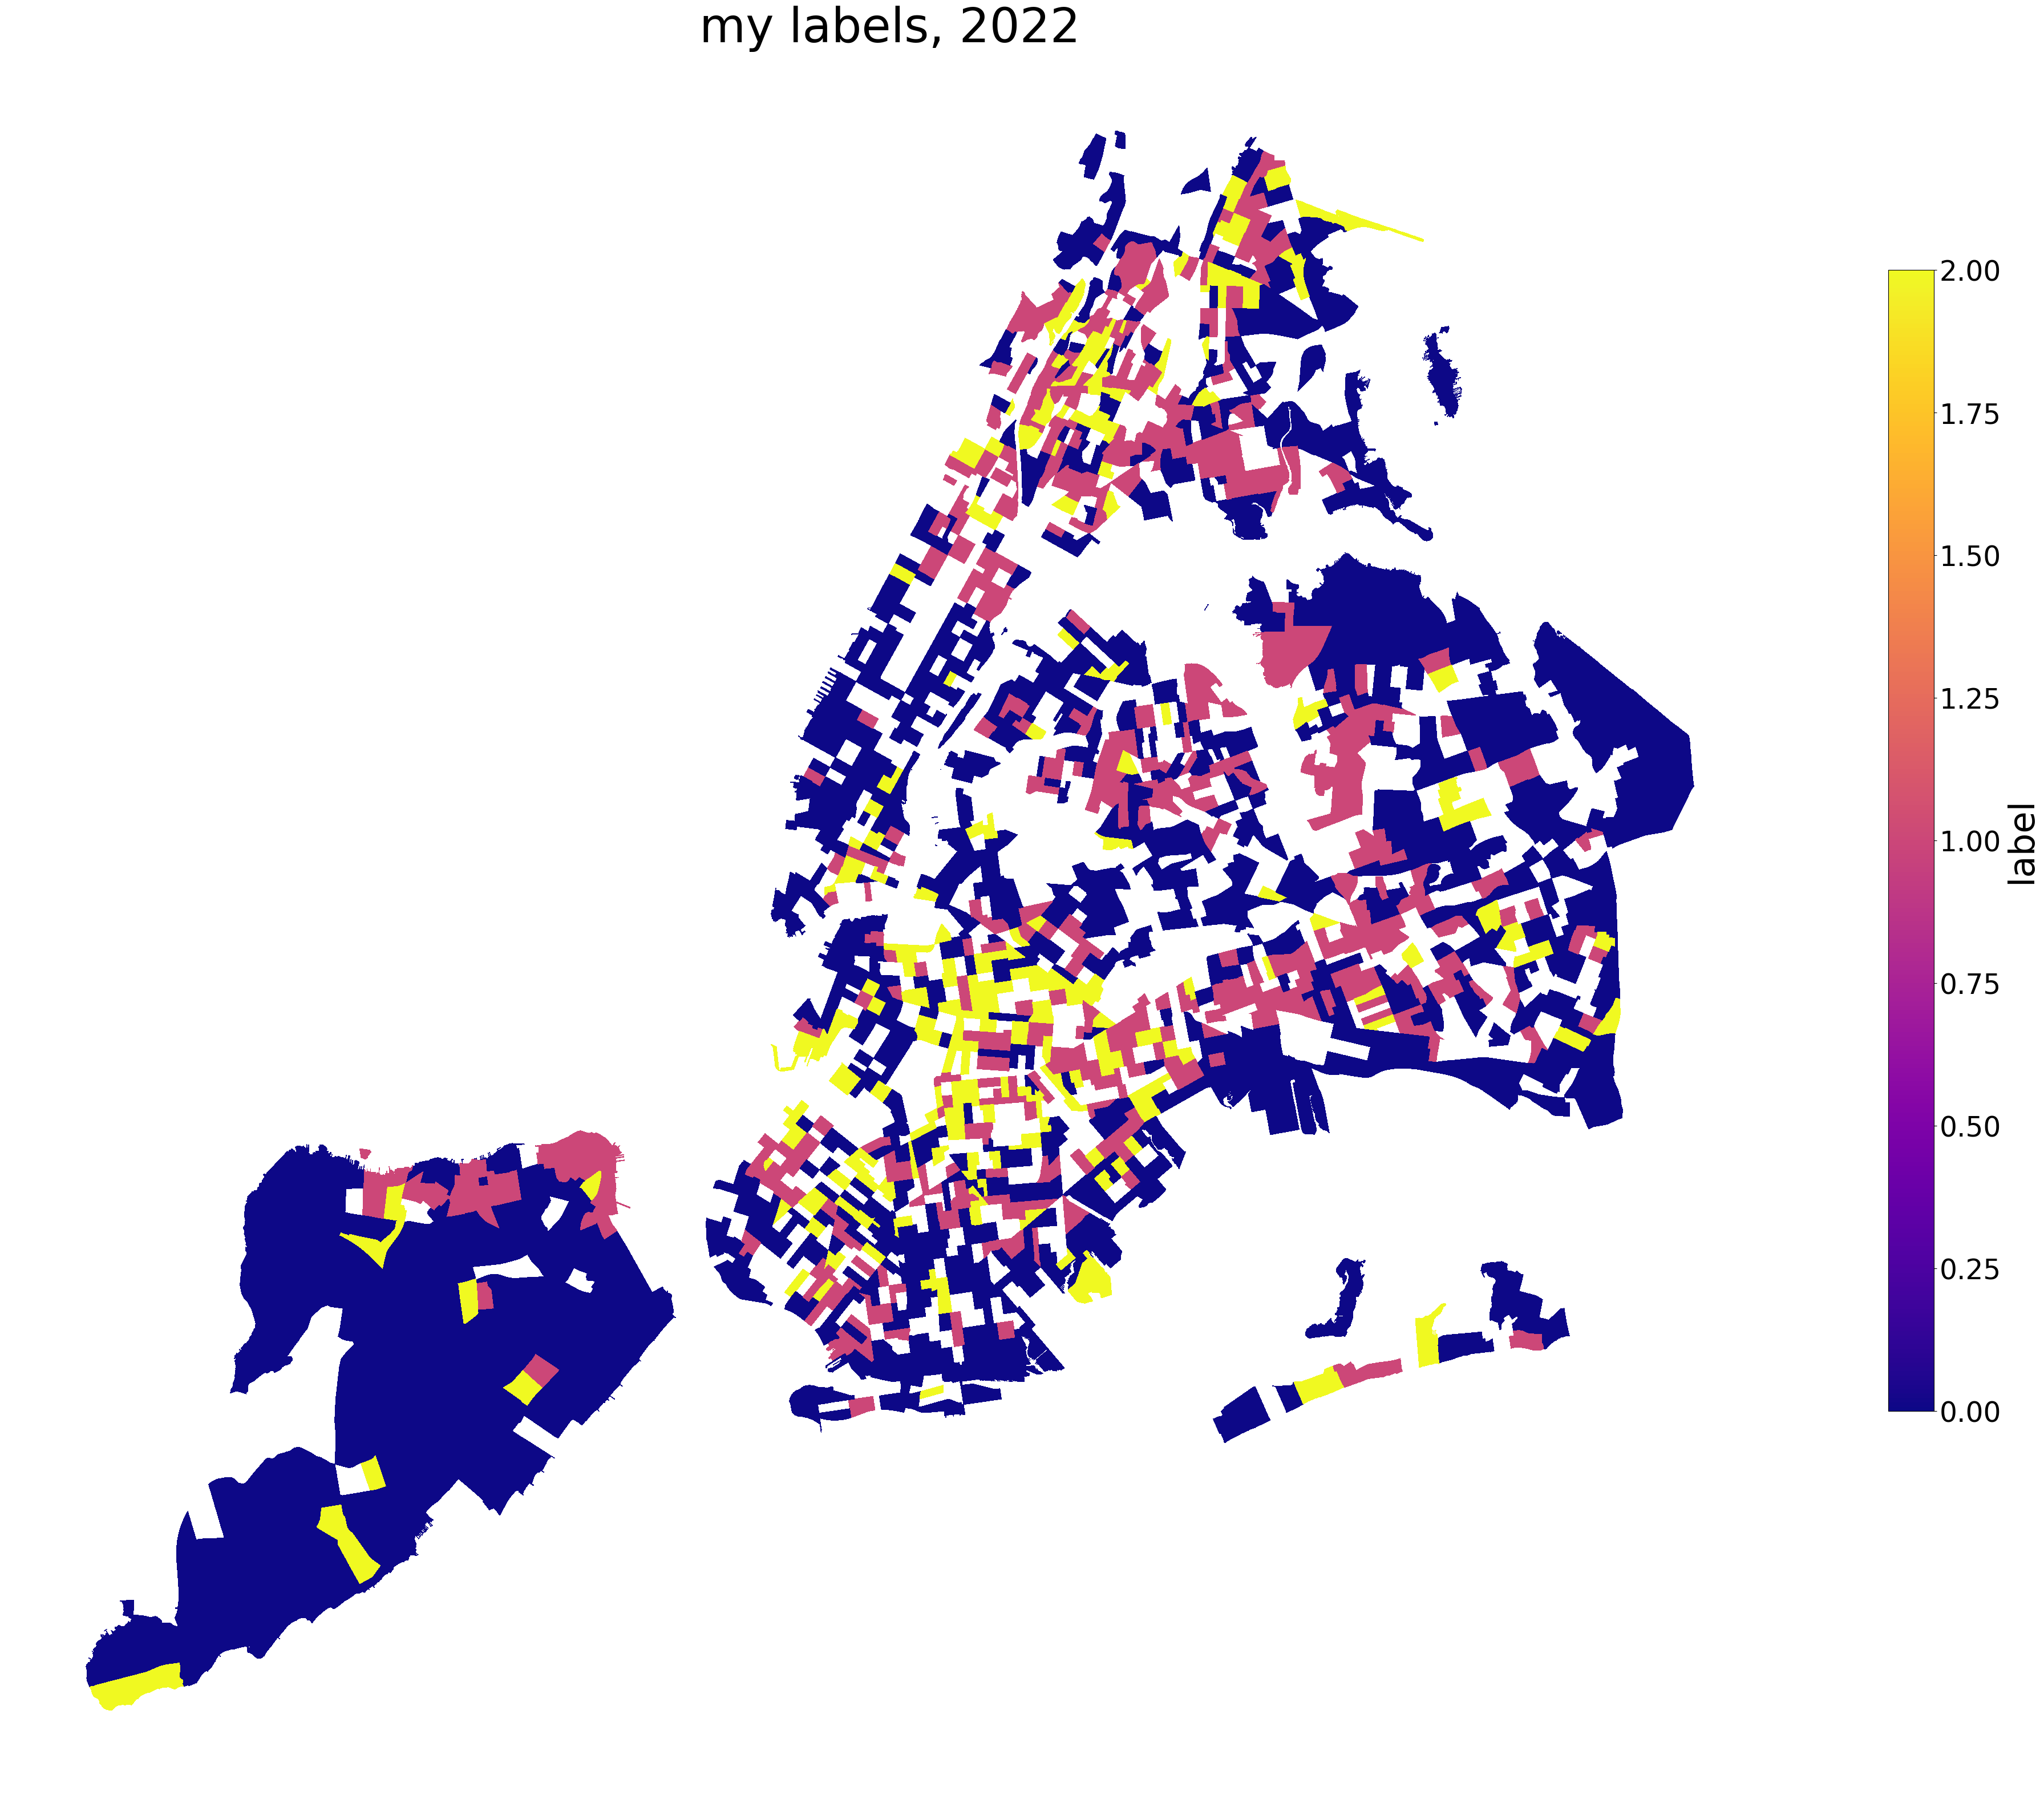

In [391]:
choropleth(labels_2020, 'label', ['2020'], cmap='plasma', title='my labels')
choropleth(labels_2022, 'label', ['2022'], cmap='plasma', title='my labels')